* Article -> https://towardsdatascience.com/forecasting-air-pollution-with-recurrent-neural-networks-ffb095763a5c
* Repo -> https://github.com/bertcarremans/air_pollution_forecasting

In this notebook, we will focus on the air quality in Belgium and more specific on the pollution by sulphur dioxide (SO2).
The file used in this notebook is `BE_1_2013–2015_aggregated_timeseries.csv`

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0'

In [3]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json

In [4]:
# Setting the project directory
project_dir = Path('/Users/robincole/Documents/data/BE_AQeReporting_2013-2015')

In [5]:
date_vars = ['DatetimeBegin','DatetimeEnd']

agg_ts = pd.read_csv(project_dir / 'BE_1_2013-2015_aggregated_timeseries.csv', sep='\t', parse_dates=date_vars, date_parser=pd.to_datetime)
meta = pd.read_csv(project_dir / 'BE_2013-2015_metadata.csv', sep='\t')

print('aggregated timeseries shape:{}'.format(agg_ts.shape))
print('metadata shape:{}'.format(meta.shape))

aggregated timeseries shape:(53647, 18)
metadata shape:(1289, 26)


In [6]:
meta.head()

,Countrycode,Timezone,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,AirQualityStationNatCode,SamplingPoint,SamplingProcess,Sample,...,Latitude,Altitude,MeasurementType,AirQualityStationType,AirQualityStationArea,EquivalenceDemonstrated,MeasurementEquipment,InletHeight,BuildingDistance,KerbDistance
0,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BEGBB15,BEGBB15,26BB15,SPO-BEGBB15_06001_100,SPP-BEGBB15_06001_1,SAM-BEGBB15_06001,...,51.213463,5,automatic,background,urban,ref,NaN,2,-999,-999
1,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BEGR701,BEGR701,26R701,SPO-BEGR701_06001_100,SPP-BEGR701_06001_1,SAM-BEGR701_06001,...,51.058332,5,automatic,background,urban,ref,NaN,2,-999,-999
2,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BEGR801,BEGR801,26R801,SPO-BEGR801_06001_100,SPP-BEGR801_06001_1,SAM-BEGR801_06001,...,51.209663,6,automatic,background,urban,ref,NaN,2,-999,-999
3,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BEGR811,BEGR811,26R811,SPO-BEGR811_06001_100,SPP-BEGR811_06001_1,SAM-BEGR811_06001,...,51.252103,8,automatic,background,suburban,ref,NaN,2,-999,-999
4,BE,http://dd.eionet.europa.eu/vocabulary/aq/timez...,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BEGRT01,BEGRT01,26RT01,SPO-BEGRT01_06001_100,SPP-BEGRT01_06001_1,SAM-BEGRT01_06001,...,51.230858,23,automatic,background,rural,ref,NaN,2,-999,-999


In [7]:
agg_ts.head()

,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,SamplingPoint,AirPollutant,AirPollutantCode,DataAggregationProcess,AirPollutionLevel,UnitOfAirPollutionLevel,DataCapture,DataCoverage,TimeCoverage,DatetimeBegin,DatetimeEnd,Validity,Verification
0,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,83.333333,83.333333,2013-03-01,2013-03-02,1,1
1,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,87.500000,87.500000,2013-02-26,2013-02-27,1,1
2,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,87.500000,87.500000,2013-08-28,2013-08-29,1,1
3,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,95.833333,95.833333,2013-02-02,2013-02-03,1,1
4,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,95.833333,95.833333,2013-02-21,2013-02-22,1,1


Let’s use pandas_profiling to inspect the data.

In [8]:
pandas_profiling.ProfileReport(agg_ts)

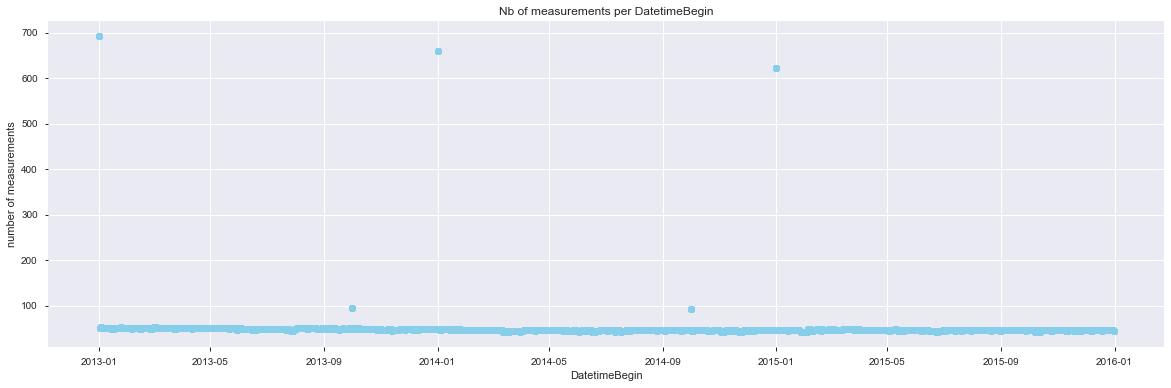

In [9]:
plt.figure(figsize=(20,6))
plt.plot(agg_ts.groupby('DatetimeBegin').count(), 'o', color='skyblue')
plt.title('Nb of measurements per DatetimeBegin')
plt.ylabel('number of measurements')
plt.xlabel('DatetimeBegin')
plt.show()

Later in this notebook, we will use measurements on prior days to predict the pollution on the current day. To have similarly sized timesteps, we will need to insert rows for the missing DatetimeBegin per SamplingPoint. We will insert the measurement data of the next day with valid data.
Secondly, we will remove the SamplingPoints with too many missing timesteps. Here we will take an arbitrary number of 1.000 timesteps as the minimum number of required timesteps.

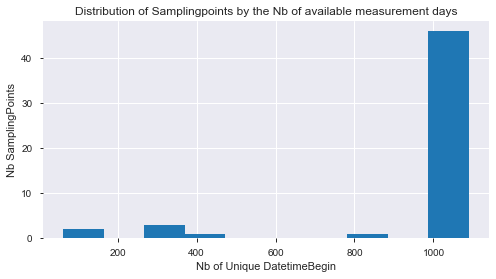

In [10]:
ser_avail_days = agg_ts.groupby('SamplingPoint').nunique()['DatetimeBegin']
plt.figure(figsize=(8,4))
plt.hist(ser_avail_days.sort_values(ascending=False))
plt.ylabel('Nb SamplingPoints')
plt.xlabel('Nb of Unique DatetimeBegin')
plt.title('Distribution of Samplingpoints by the Nb of available measurement days')
plt.show()

## Data Cleaning
Based on the data exploration, we will do the following to clean the data:
* Keeping only records with DataAggregationProcess of P1D
* Removing records with UnitOfAirPollutionLevel of count
* Removing unary variables and other redundant variables
* Removing SamplingPoints which have less than 1000 measurement days

In [11]:
df = agg_ts.loc[agg_ts.DataAggregationProcess=='P1D', :] 
df = df.loc[df.UnitOfAirPollutionLevel!='count', :]
df = df.loc[df.SamplingPoint.isin(ser_avail_days[ser_avail_days.values >= 1000].index), :]
vars_to_drop = ['AirPollutant','AirPollutantCode','Countrycode','Namespace','TimeCoverage','Validity','Verification','AirQualityStation',
               'AirQualityStationEoICode','DataAggregationProcess','UnitOfAirPollutionLevel', 'DatetimeEnd', 'AirQualityNetwork',
               'DataCapture', 'DataCoverage']
df.drop(columns=vars_to_drop, axis='columns', inplace=True)

In [12]:
df.head()

,SamplingPoint,AirPollutionLevel,DatetimeBegin
401,SPO-BELHB23_00001_100,1.0,2013-05-22
402,SPO-BELHB23_00001_100,1.0,2013-01-04
403,SPO-BELHB23_00001_100,1.0,2013-02-25
404,SPO-BELHB23_00001_100,1.0,2013-02-27
405,SPO-BELHB23_00001_100,1.0,2013-03-11


## Inserting rows for the missing timesteps
For each SamplingPoint, we will first insert (empty) rows for which we do not have a DatetimeBegin. This can be done by creating a complete multi-index with all SamplingPoints and over the range between the minimum and maximum DatetimeBegin. Then, reindex will insert the missing rows but with NaN for the columns.

Secondly, we use bfill and specify to impute the missing values with the values of the next row with valid data. The bfill method is applied to a groupby object to limit the backfilling within the rows of each SamplingPoint. That way we do not use the values of another SamplingPoint to fill in the missing values.

In [13]:
dates = list(pd.period_range(min(df.DatetimeBegin), max(df.DatetimeBegin), freq='D').values)
samplingpoints = list(df.SamplingPoint.unique())

new_idx = []
for sp in samplingpoints:
    for d in dates:
        new_idx.append((sp, np.datetime64(d)))

df.set_index(keys=['SamplingPoint', 'DatetimeBegin'], inplace=True)
df.sort_index(inplace=True)
df = df.reindex(new_idx)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # should contain NaN for the columns

df['AirPollutionLevel'] = df.groupby(level=0).AirPollutionLevel.bfill().fillna(0)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # NaN are replaced by values of 2013-01-30
print('{} missing values'.format(df.isnull().sum().sum()))

0 missing values


In [14]:
df.head()

AirPollutionLevel
SamplingPoint         DatetimeBegin                   
SPO-BELHB23_00001_100 2013-01-01             28.195652
                      2013-01-02             55.978261
                      2013-01-03              2.666667
                      2013-01-04              1.000000
                      2013-01-05              1.739130

## Handling multiple time series
Alright, now we have a data set that is cleaned and does not contain any missing values. One aspect that makes this data set particular is that we have data for multiple samplingpoints. So we have multiple time series.
One way to deal with that is to create dummy variables for the samplingpoints and use all records to train the model. Another way is to build a separate model per samplingpoint. In this notebook, we will do the latter. We will, however, limit the notebook to do that for only one samplingpoint. But the same logic can be applied to every samplingpoint.

In [15]:
df = df.loc['SPO-BETR223_00001_100',:]

In [16]:
df.head()

,AirPollutionLevel
DatetimeBegin,
2013-01-01,1.847826
2013-01-02,0.000000
2013-01-03,0.000000
2013-01-04,0.000000
2013-01-05,0.000000


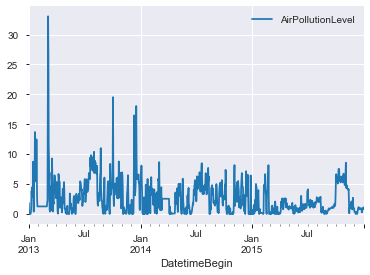

In [17]:
df.plot();

## Split train, test and validation set
We split off a test set in order to evaluate the performance of the model. The test set will not be used during the training phase.
* train set: data until July 2014
* validation set: 6 months between July 2014 and January 2015
* test set: data of 2015

In [18]:
train = df.query('DatetimeBegin < "2014-07-01"')
valid = df.query('DatetimeBegin >= "2014-07-01" and DatetimeBegin < "2015-01-01"')
test = df.query('DatetimeBegin >= "2015-01-01"')

## Scaling

In [20]:
# Save column names and indices to use when storing as csv
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
valid = scaler.transform(valid)
test = scaler.transform(test)

create a function to plot the training and validation loss for the different models we will build.

In [21]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

## Prepare data with the TimeseriesGenerator
The [TimeseriesGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator) helps us building the data in the correct format for modeling.
* `length`: number of timesteps in the generated sequence. Here we want to look back an arbitrary number of n_lag timesteps. In reality, n_lag could depend on how the predictions will be used. Suppose the Belgian government can take some actions to reduce the SO2 pollution around a samplingpoint (for instance prohibit the entrance of diesel cars in a city for a certain period of time). And suppose the government needs 14 days before the corrective actions can go in effect. Then it would make sense to set n_lag to 14.
* `sampling_rate`: number of timesteps between successive timesteps in the generated sequence. We want to keep all timesteps, so we leave this to the default of 1.
* `stride`: this parameter influences how much the generated sequences will overlap. As we do not have much data, we leave it to the default of 1. This means that two sequences generated after one another overlap with all timesteps except one.
* `batch_size`: number of generated sequences in each batch

In [22]:
n_lag = 14

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

## Recurrent Neural Networks
Traditional neural networks have no memory. Consequently, they do not take into account previous input when processing the current input. In sequential data sets, like time series, the information of previous time steps is typically relevant for predicting something in the current step. So a state about the previous time steps needs to be maintained.

In our case, the air pollution at time `t` might be influenced by air pollution in previous timesteps. So we need to take that into account. Recurrent Neural Networks or RNNs have an internal loop by which they maintain a state of previous timesteps. This state is then used for the prediction in the current timestep. The state is reset when a new sequence is being processed.

For our case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN). We also specify an `EarlyStopping` callback to stop the training when there were 10 epochs without any improvement in the validation loss. The `ModelCheckpoint` allows us to save the weights of the best model. The model architecture still needs to be saved separately.

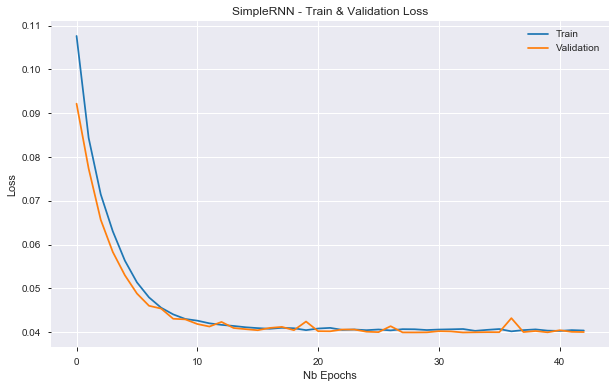

Minimum validation loss of 0.03992558147570493 reached at epoch 32


In [23]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(n_lag, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='simple_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)

with open("simple_rnn.json", "w") as m:
    m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen
                                              , epochs=100
                                              , validation_data=valid_data_gen
                                              , verbose=0
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

## Long Short Term Memory Networks
An RNN has a short memory. It has difficulty to remember information of many timesteps ago. This occurs when the sequences are very long. In fact, it is due to the vanishing gradient problem. The gradients are values that update the weights of a neural network. When you have many timesteps in your RNN the gradient for the first layers becomes very tiny. As a result, the update of the weights of the first layers is negligible. This means that the RNN is not capable of learning what was in the early layers.
So we need a way to carry the information of the first layers to later layers. LSTMs are better suited to take into account long-term dependencies.

In [ ]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(4, input_shape=(n_lag, 1)))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='simple_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)

with open("simple_lstm.json", "w") as m:
    m.write(simple_lstm.to_json())

simple_lstm_history = simple_lstm.fit_generator(train_data_gen
                                                , epochs=100
                                                , validation_data=valid_data_gen
                                                , verbose=0
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(simple_lstm_history, 'Simple LSTM - Train & Validation Loss')